In [47]:
"""Load Data
Structure:
    1. Imports, Variables, Functions
    2. Load Data
"""

# 1. Imports, Variables, Functions
# imports
import pandas as pd, numpy as np, os, sys
import anndata as ad
import logging
from typing import *
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.metrics import confusion_matrix, classification_report

logging.basicConfig(level=logging.INFO)

# variables
run_dirs = [
    os.path.join("..", "outputs", "run-24-09-25-09"),
    os.path.join("..", "outputs", "run-24-09-25-10"),
]

labels = ["nº splits = 3", "nº splits = 5"]

for run_dir in run_dirs:
    output_dir = os.path.join(run_dir, "outputs")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

# functions


def load_run_output(input_dir: str) -> tuple:
    """Load the output of a run
    Args:
        input_dir (str): path to the run output directory
    Returns:
        loaded_variables (tuple): tuple of loaded variables
    """

    variables_to_load = [
        "split",
        "predictions_test",
        "labels_test",
        "results_test",
        "all_outputs_test",
        "predictions_train",
        "labels_train",
        "results_train",
        "all_outputs_train",
        "adata_orig",
        "id2type",
    ]

    # initialize loaded variables as an empty tuple
    loaded_variables = ()

    # loop through variables
    for variable in variables_to_load:
        if variable.startswith("adata"):
            loaded_variable = ad.read_h5ad(os.path.join(input_dir, f"{variable}.h5ad"))
        else:
            with open(os.path.join(input_dir, f"{variable}.pkl"), "rb") as f:
                loaded_variable = pickle.load(f)

        # add the loaded variable to the tuple
        loaded_variables += (loaded_variable,)

    print(f"Nº of loaded variables {len(loaded_variables)}")

    return loaded_variables


# 2. Load Data
stored_data = {
    "labels": list(),
    "predictions_test": list(),
    "labels_test": list(),
    "results_test": list(),
    "all_outputs_test": list(),
    "predictions_train": list(),
    "labels_train": list(),
    "results_train": list(),
    "all_outputs_train": list(),
    "id2type": list(),
}


for label, run_dir in zip(labels, run_dirs):

    (
        split,
        predictions_test,
        labels_test,
        results_test,
        all_outputs_test,
        predictions_train,
        labels_train,
        results_train,
        all_outputs_train,
        adata_orig,
        id2type,
    ) = load_run_output(run_dir)

    stored_data["labels"].append(label)
    stored_data["predictions_test"].append(predictions_test)
    stored_data["labels_test"].append(labels_test)
    stored_data["results_test"].append(results_test)
    stored_data["all_outputs_test"].append(all_outputs_test)
    stored_data["predictions_train"].append(predictions_train)
    stored_data["labels_train"].append(labels_train)
    stored_data["results_train"].append(results_train)
    stored_data["all_outputs_train"].append(all_outputs_train)
    stored_data["id2type"].append(id2type)

output_dir = "tmp_outputs"

Nº of loaded variables 11
Nº of loaded variables 11


In [48]:
data_performance = list()
for j in range(len(labels)):
    for i in range(0, len(stored_data["results_test"][j])):
        data_performance.append(
            {
                "accuracy": stored_data["results_test"][j][i]["test/accuracy"],
                "precision": stored_data["results_test"][j][i]["test/precision"],
                "recall": stored_data["results_test"][j][i]["test/recall"],
                "macro_f1": stored_data["results_test"][j][i]["test/macro_f1"],
                "type": "test",
                "label": stored_data["labels"][j],
            }
        )
        data_performance.append(
            {
                "accuracy": stored_data["results_train"][j][i]["test/accuracy"],
                "precision": stored_data["results_train"][j][i]["test/precision"],
                "recall": stored_data["results_train"][j][i]["test/recall"],
                "macro_f1": stored_data["results_train"][j][i]["test/macro_f1"],
                "type": "train",
                "label": stored_data["labels"][j],
            }
        )

    df_performance = pd.DataFrame(data_performance)

In [49]:
df_performance

,accuracy,precision,recall,macro_f1,type,label
0,0.707099,0.612521,0.464316,0.446962,test,nº splits = 3
1,0.857556,0.801869,0.704917,0.737940,train,nº splits = 3
2,0.730086,0.547979,0.533434,0.507809,test,nº splits = 3
3,0.863248,0.869689,0.807322,0.808428,train,nº splits = 3
4,0.516698,0.445542,0.500188,0.458760,test,nº splits = 3
5,0.840619,0.732211,0.762480,0.744716,train,nº splits = 3
6,0.756238,0.503805,0.404235,0.432513,test,nº splits = 5
7,0.843990,0.767903,0.678621,0.711657,train,nº splits = 5
8,0.750499,0.558444,0.578371,0.566580,test,nº splits = 5
9,0.865131,0.771252,0.734197,0.749615,train,nº splits = 5


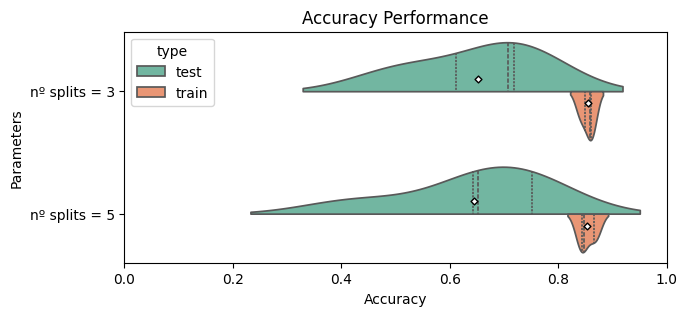

In [55]:
plt.figure(figsize=(7, 3))
sns.violinplot(
    data=df_performance,
    y="label",
    x="accuracy",
    hue="type",
    split=True,
    inner="quartile",
    palette="Set2",
    orient="h",
)


# Calculate the means for each combination of label and type
means = df_performance.groupby(["label", "type"])["accuracy"].mean().reset_index()

# Plot the means on the violin plot
for i, label in enumerate(means["label"].unique()):
    label_means = means[means["label"] == label]
    plt.scatter(
        label_means["accuracy"],
        [i - 0.1, i + 0.1],
        color="white",
        marker="D",
        label="Mean" if i == 0 else "",
        zorder=3,
        s=12,
        edgecolors="black",
    )

plt.xlim(0, 1)
plt.ylabel("Parameters")
plt.xlabel("Accuracy")
plt.title("Accuracy Performance")
plt.savefig(
    os.path.join(output_dir, "performance.accuracy.png"), dpi=300, bbox_inches="tight"
)

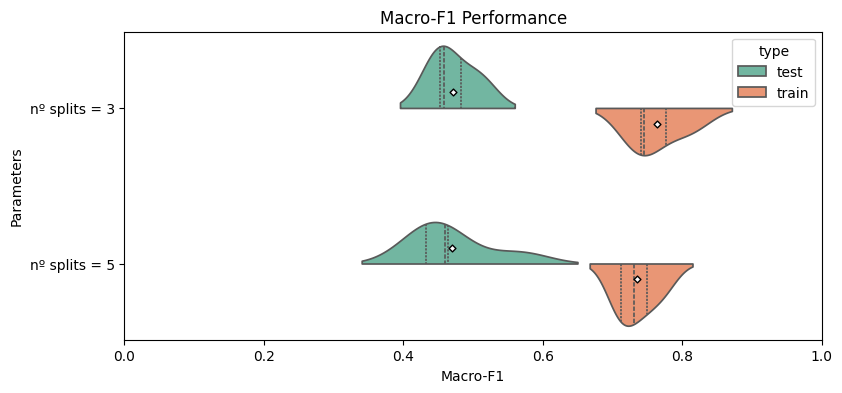

In [54]:
plt.figure(figsize=(7, 3))
sns.violinplot(
    data=df_performance,
    y="label",
    x="macro_f1",
    hue="type",
    split=True,
    inner="quartile",
    palette="Set2",
    orient="h",
)


# Calculate the means for each combination of label and type
means = df_performance.groupby(["label", "type"])["macro_f1"].mean().reset_index()

# Plot the means on the violin plot
for i, label in enumerate(means["label"].unique()):
    label_means = means[means["label"] == label]
    plt.scatter(
        label_means["macro_f1"],
        [i - 0.1, i + 0.1],
        color="white",
        marker="D",
        label="Mean" if i == 0 else "",
        zorder=3,
        s=12,
        edgecolors="black",
    )

plt.xlim(0, 1)
plt.ylabel("Parameters")
plt.xlabel("Macro-F1")
plt.title("Macro-F1 Performance")
plt.savefig(
    os.path.join(output_dir, "performance.f1.png"), dpi=300, bbox_inches="tight"
)

In [43]:
df_performance

,accuracy,precision,recall,macro_f1,type,label
0,0.707099,0.612521,0.464316,0.446962,test,nº splits = 3
1,0.857556,0.801869,0.704917,0.737940,train,nº splits = 3
2,0.730086,0.547979,0.533434,0.507809,test,nº splits = 3
3,0.863248,0.869689,0.807322,0.808428,train,nº splits = 3
4,0.516698,0.445542,0.500188,0.458760,test,nº splits = 3
5,0.840619,0.732211,0.762480,0.744716,train,nº splits = 3
6,0.756238,0.503805,0.404235,0.432513,test,nº splits = 5
7,0.843990,0.767903,0.678621,0.711657,train,nº splits = 5
8,0.750499,0.558444,0.578371,0.566580,test,nº splits = 5
9,0.865131,0.771252,0.734197,0.749615,train,nº splits = 5


In [28]:
[label] * len(label_means)

['nº splits = 3', 'nº splits = 3']

In [26]:
label_means["accuracy"]

2    0.645248
3    0.852849
Name: accuracy, dtype: float64